# Half-wave dipole
In this notebook, a center-driven half-wave dipole is modeled using the thin-wire MoM implementation.
 - Current distribution at resonance
 - Input impedance versus frequency
 - Far-field radiation pattern

In [1]:
using CairoMakie
using TimerOutputs

include("../src/Mesh.jl")
include("../src/Sources.jl")
include("../src/Matrix.jl")
include("../src/PostProcessing.jl")
include("../src/Visualization.jl")

plot_mesh (generic function with 1 method)

In [2]:
ε = 8.854e-12      # Vacuum permittivity [F/m]
μ = 4e-7 * π       # Vacuum permeability [H/m]

c = 1 / √(μ * ε)   # Speed of light in vacuum [m/s]
η = √(μ / ε)       # Impedance of vacuum [Ω]

376.73430918211017

# Generate mesh
Generate the mesh consisting of a single segment with $N_{el}$ elements. For the wire radius $a = 10^{-3}$, the antenna is resonant when it has a length of $0.479 \lambda$. The antenna wire is placed along the $y$-axis.

In [3]:
Nel = 35
l = (c / 144e6) * 0.479
a = 1e-3

nodes, edges = mesh_segment([0 -l / 2 0], [0 l / 2 0], Nel, 1)
end_points = get_end_points(nodes, edges)
basis_vecs = assign_basis_vector(nodes, edges)

msh = Mesh(nodes, edges, end_points, basis_vecs, a)

Mesh([0.0 -0.4986184390800368 0.0; 0.0 -0.47012595684689185 0.0; … ; 0.0 0.47012595684689185 0.0; 0.0 0.4986184390800368 0.0], [[1, 2], [2, 3], [3, 4], [4, 5], [5, 6], [6, 7], [7, 8], [8, 9], [9, 10], [10, 11]  …  [26, 27], [27, 28], [28, 29], [29, 30], [30, 31], [31, 32], [32, 33], [33, 34], [34, 35], [35, 36]], [1, 36], [0.0 -1.0 0.0; 0.0 -1.0 0.0; … ; 0.0 -1.0 0.0; 0.0 -1.0 0.0], 0.001)

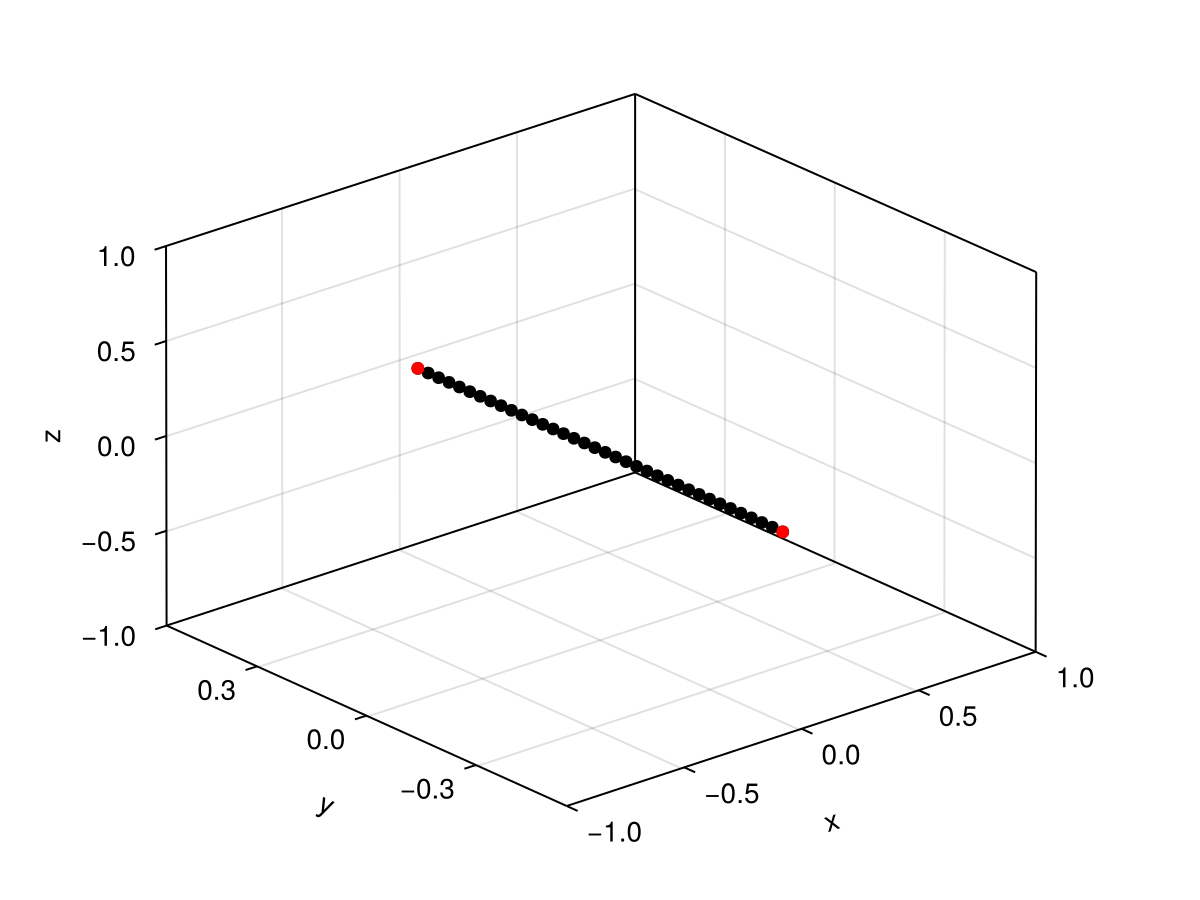

In [4]:
# Plot the antenna in 3D
f_msh = plot_mesh(msh)
f_msh

# Sources
The antenna is fed in the middle by a delta-gap voltage source $V_{in}$.

In [5]:
# Mid-point feed
Vin = 1
idx_mid = Integer(ceil(Nel / 2)) # Index of center element
src1 = VoltageSource(Vin, idx_mid)

src = [src1]

1-element Vector{VoltageSource}:
 VoltageSource(1, 18)

# Current distribution
The current distribution at resonance, and the corresponding input impedance are calculated.

Note that the imaginary part of the impedance is almost zero, indicating that the antenna is resonant at this frequency. The real part is very close to the ideally expected $73.1\,\Omega$.

In [6]:
reset_timer!()

# Assemble system equations
@timeit "assemble" Z, V = assemble_global(msh, src, 144e6, μ, ε)

# Solve system
@timeit "solve" Isol = Z \ V

print_timer()

# Calculate input impedance
e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

println("\n\nImpedance at resonance: ", Zin, " Ω")

─────────────────────────────────────────────────────────────────────────
                                Time                    Allocations      
                       ───────────────────────   ────────────────────────
   Tot / % measured:        4.35s /  92.3%            378MiB /  93.2%    

Section        ncalls     time    %tot     avg     alloc    %tot      avg
─────────────────────────────────────────────────────────────────────────
assemble            1    2.64s   65.7%   2.64s    219MiB   62.4%   219MiB
  outer loop        1    1.63s   40.5%   1.63s    141MiB   40.1%   141MiB
    element     1.23k    965ms   24.0%   788μs   97.0MiB   27.6%  81.1KiB
solve               1    1.38s   34.3%   1.38s    132MiB   37.6%   132MiB
─────────────────────────────────────────────────────────────────────────


Impedance at resonance: 71.90833200881792 + 0.20500766924736735im Ω


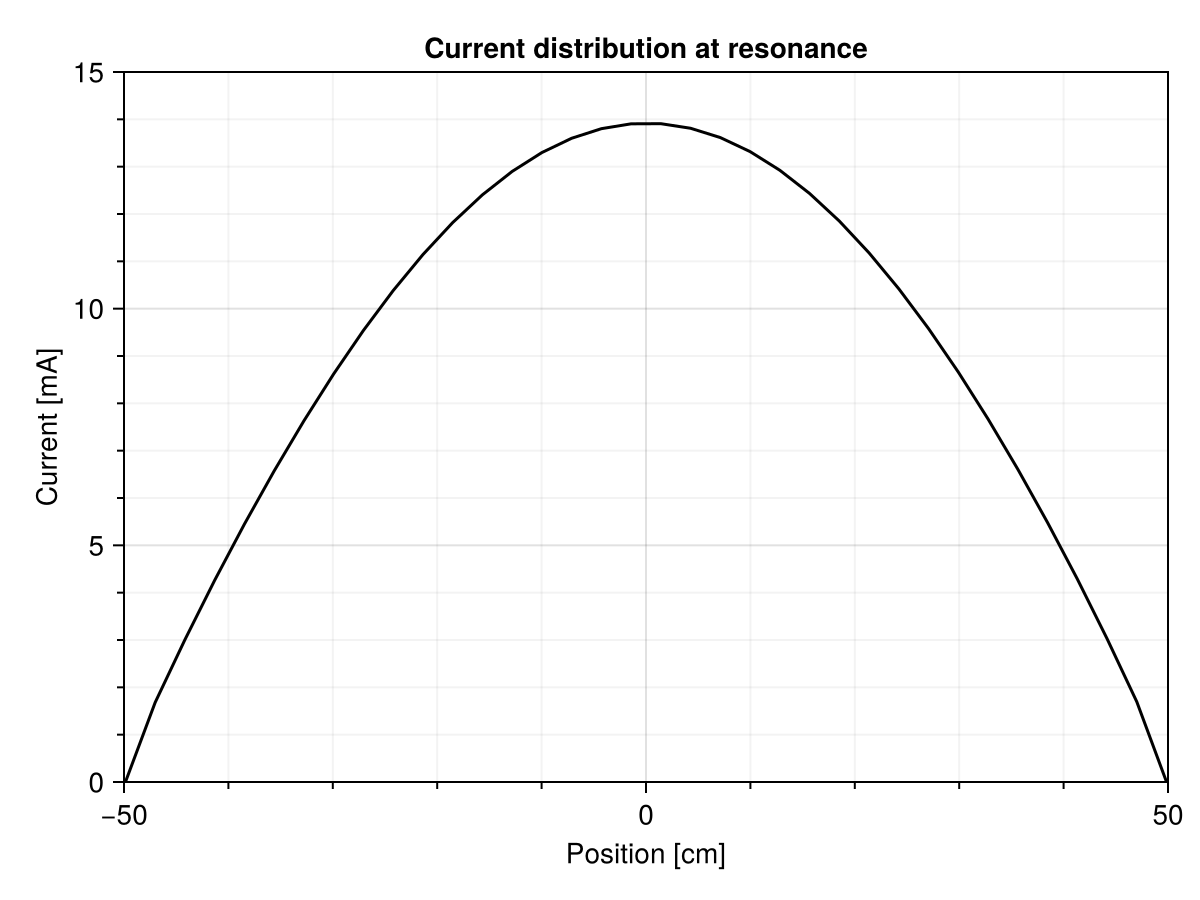

In [7]:
f = Figure()
ax = Axis(
    f[1, 1],
    xlabel="Position [cm]", ylabel="Current [mA]", title="Current distribution at resonance",
    limits=(-50, 50, 0, 15),
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    yminorticksvisible=true, yminorgridvisible=true, yminorticks=IntervalsBetween(5),
)

lines!(ax, msh.nodes[:, 2] * 1e2, abs.(Isol) * 1e3, color = :black)

f

# Frequency sweep
Next, we can solve the current distribution for a range of frequencies and plot the input impedance vs frequency.

In [8]:
# Input impedance frequency sweep
frequencies = range(50e6, 300e6, 50)
Zin = zeros(Complex{Float64}, length(frequencies))

reset_timer!()

@timeit "frequency sweep" for (i, f) ∈ enumerate(frequencies)
    # Assemble system equations
    @timeit "assembly" Z, V = assemble_global(msh, src, f, μ, ε)

    # Solve system
    @timeit "solve" Isol = Z \ V

    # Calculate input impedance
    e = msh.edges[src[1].edge]
    Iin = sum(Isol[e]) / length(Isol[e])
    Zin[i] = Vin / Iin
end

print_timer()

────────────────────────────────────────────────────────────────────────────
                                   Time                    Allocations      
                          ───────────────────────   ────────────────────────
    Tot / % measured:          2.96s /  96.4%           1.85GiB /  99.9%    

Section           ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────
frequency sweep        1    2.85s  100.0%   2.85s   1.85GiB  100.0%  1.85GiB
  assembly            50    2.82s   99.0%  56.5ms   1.85GiB   99.9%  37.8MiB
    outer loop        50    2.82s   98.9%  56.5ms   1.84GiB   99.9%  37.8MiB
      element      61.2k    2.34s   82.1%  38.2μs   1.75GiB   94.6%  29.9KiB
  solve               50   2.05ms    0.1%  41.0μs   1.04MiB    0.1%  21.3KiB
────────────────────────────────────────────────────────────────────────────


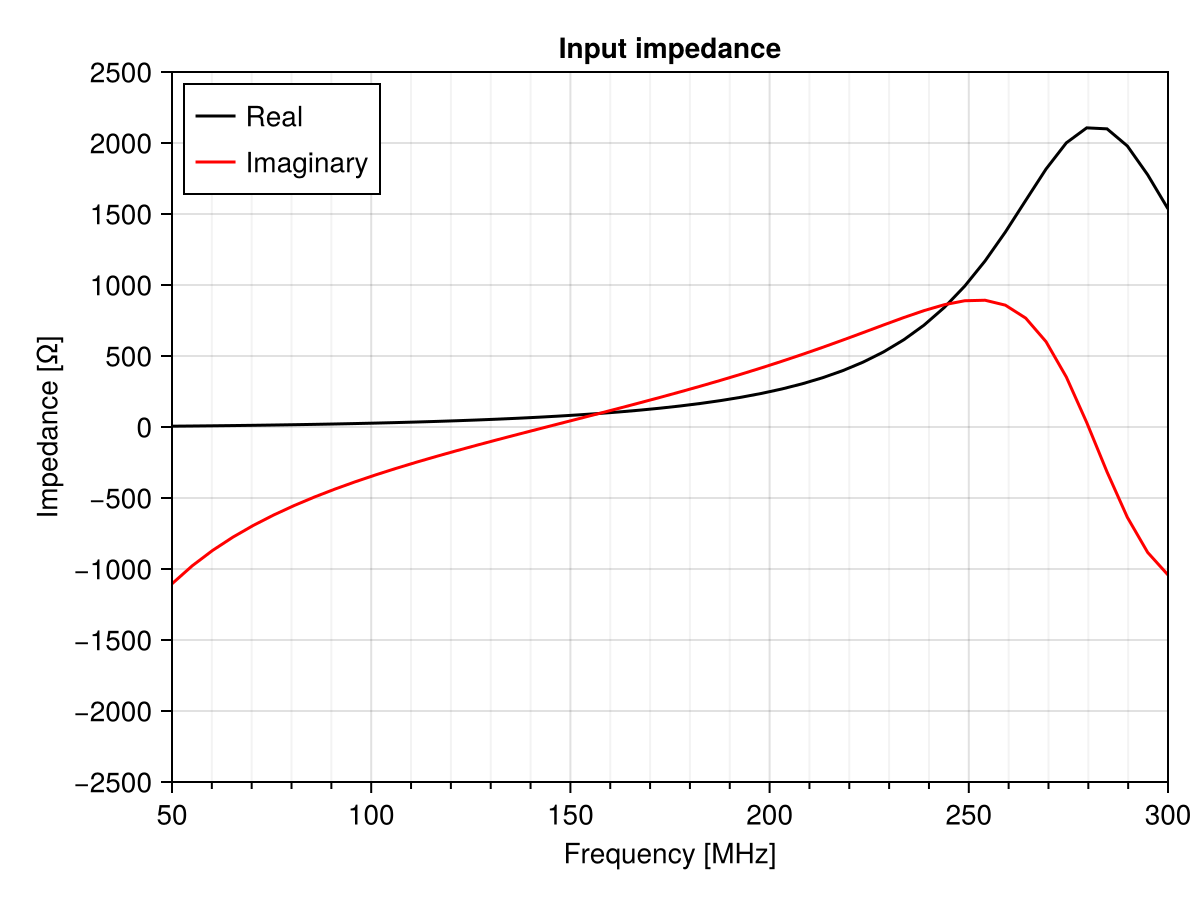

In [9]:
fig = Figure()
ax = Axis(
    fig[1, 1],
    xlabel="Frequency [MHz]", ylabel="Impedance [Ω]", title="Input impedance",
    limits=(50, 300, -2500, 2500),
    xminorticksvisible=true, xminorgridvisible=true, xminorticks=IntervalsBetween(5),
    yticks=-2500:500:2500
)

lines!(ax, frequencies * 1e-6, real.(Zin), color=:black, label="Real")
lines!(ax, frequencies * 1e-6, imag.(Zin), color=:red, label="Imaginary")
axislegend(position = :lt)

fig

# Far-field radiation pattern
The far-field radiation pattern is calculated using the far-field approximation at a distance of $100 \lambda$ from the antenna.

In [10]:
f = 144e6

# Solve currents
Z, V = assemble_global(msh, src, f, μ, ε)
Isol = Z \ V

# Calculate input impedance
e = msh.edges[src[1].edge]
Iin = sum(Isol[e]) / length(Isol[e])
Zin = Vin / Iin

reset_timer!()

# Calculate far field E-field
R = 100 * (c / f)       # Radius of evaluation points
N = 100                 # Number of evaluation points
θs = range(0, 2π, N)    # Evaluation angles

coords_xy = zeros(N, 3)
coords_xz = zeros(N, 3)
for (i, θ) ∈ enumerate(θs)
    coords_xy[i, :] = [(R * cos(θ)) (R * sin(θ)) 0]
    coords_xz[i, :] = [(R * cos(θ)) 0 (R * sin(θ))]
end

@timeit "FarField - xy" Exy = CalcFarField(msh, Isol, coords_xy, f, μ, ε);
@timeit "FarField - xz" Exz = CalcFarField(msh, Isol, coords_xz, f, μ, ε);

Pavg = Vin^2 / real(Zin) / (4π * R^2) # Power density of isotropic radiator

Pxy = norm.(eachrow(Exy)).^2 / η
Pxz = norm.(eachrow(Exz)).^2 / η

print_timer()

# Ideal E-field and radiated power for a half-wave dipole
Eideal = η * Vin / (2π * R * real(Zin)) * cos.(π/2 * cos.(θs .+ π/2)) ./ sin.(θs .+ π/2);
Pideal = Eideal.^2 / η;

────────────────────────────────────────────────────────────────────────────────
                                       Time                    Allocations      
                              ───────────────────────   ────────────────────────
      Tot / % measured:            2.25s /  76.3%            405MiB /  87.1%    

Section               ncalls     time    %tot     avg     alloc    %tot      avg
────────────────────────────────────────────────────────────────────────────────
FarField - xy              1    1.70s   99.2%   1.70s    344MiB   97.6%   344MiB
  evaluation loop          1    796ms   46.4%   796ms    218MiB   62.0%   218MiB
    loop over edges      100    796ms   46.3%  7.96ms    218MiB   61.9%  2.18MiB
FarField - xz              1   14.3ms    0.8%  14.3ms   8.59MiB    2.4%  8.59MiB
  evaluation loop          1   14.3ms    0.8%  14.3ms   8.58MiB    2.4%  8.58MiB
    loop over edges      100   14.2ms    0.8%   142μs   8.39MiB    2.4%  85.9KiB
───────────────────────────

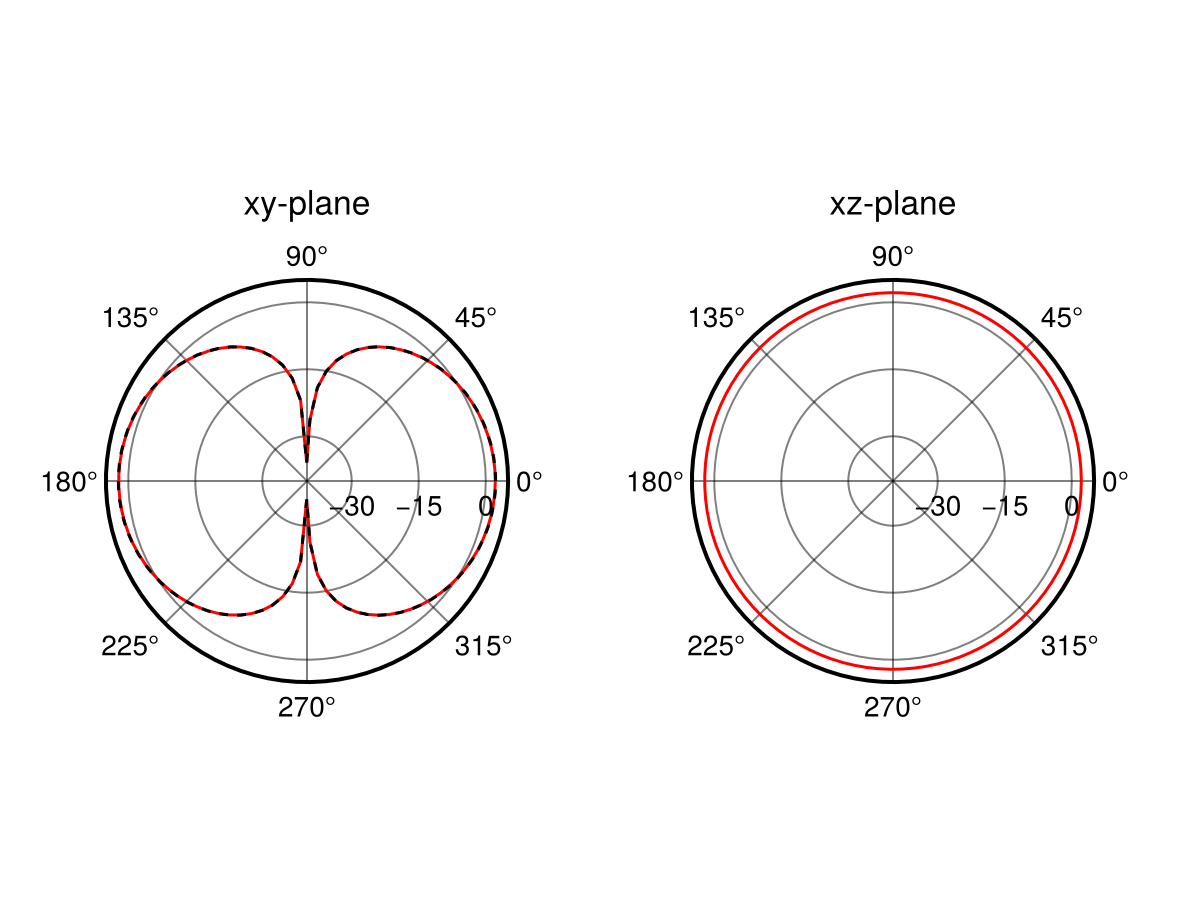

In [11]:
fig = Figure()

ax = PolarAxis(fig[1,1], rlimits = (-40, 5), radius_at_origin = -40, title = "xy-plane")
lines!(ax, θs, 10 * log10.(Pxy / Pavg), color = :red)
lines!(ax, θs, 10 * log10.(Pideal / Pavg), color = :black, linestyle = :dash)

ax = PolarAxis(fig[1,2], rlimits = (-40, 5), radius_at_origin = -40, title = "xz-plane")
lines!(ax, θs, 10 * log10.(Pxz / Pavg), color = :red)

fig

Comparing the gain (expressed linearly or in terms of decibels compared to an isotropic radiator) with the the ideally expected gain shows a $2\,\%$ deviation.

In [12]:
Gain = maximum(Pxy / Pavg) # Gain 
Gideal = maximum(Pideal / Pavg); # Theoretical gain = 2.14 dBi

err = (Gain - Gideal) / Gideal * 100

println("Error w.r.t idealized model: ", err, " %")

Error w.r.t idealized model: -1.9088635605896447 %


The same antenna is modeled using EZNEC. At an angle of $45^\circ$, EZNEC gives a gain of $-4.01\,\textrm{dBmax} \equiv -1.87\,\textrm{dBi}$.

In [13]:
θ = 45π / 180
Efront = CalcFarField(msh, Isol, [R 0 0], f, μ, ε);
Eside = CalcFarField(msh, Isol, [R * cos(θ) R * sin(θ) 0], f, μ, ε);

Pfront = norm(Efront)^2 / η
Pside = norm(Eside)^2 / η

# Calculate the front-to-side ratio in dB
# Result from EZNEC: 4.01 dB
Rfs = 10 * log10(Pfront / Pside)

4.005644598338418